# Effectiveness Optimizer

This document looks at flight logs from a Bebop drone with:

- ASC controller structure
- Filtered Gyro Signal
- Complementary Filter

It tries to look at how good the estimation of the rotational acceleration is in the complementary filter and it tries to provide a new solution for the effectiveness matrix, so that the estimation in the conmplementary filter matches the actual filtered state signal. We compare then the filtered estimation with the filtered readings to provide the matrix, for each state. 

In [1]:
# packages

%matplotlib notebook
import pandas as pd
import numpy as np
from math import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize, Bounds
import seaborn as sns
import matplotlib.transforms as mtransforms
from scipy import signal
import scipy as sp

## 1. Build and look at the dataframe

In [16]:
# read the data file
filename = "test_data/effectiveness_flights/flight_50.csv"
df = pd.read_csv(filename)

# crop and get interested segment
start_log = 0.2
end_log = 0.7
n_samples = len(df.time)

df_crop = df.truncate(int(start_log*n_samples),int(end_log*n_samples))
n_samples_crop = len(df_crop.time)

print(f"New samples: {n_samples_crop}")

New samples: 15707


<IPython.core.display.Javascript object>


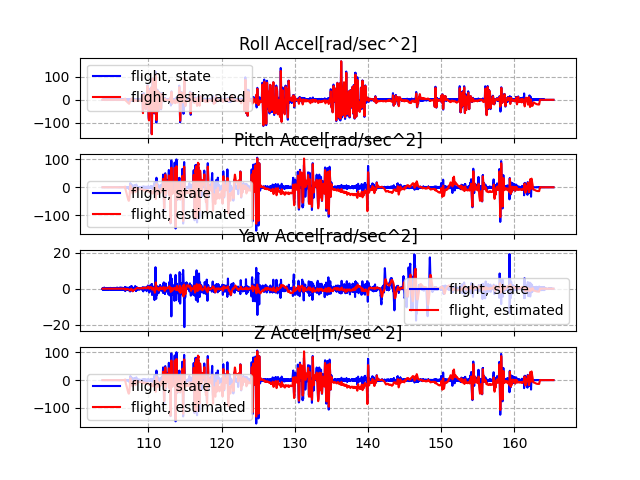

Text(0.5, 1.0, 'Z Accel[m/sec^2]')

In [17]:
# check that the difference between the flight with and wo plate affect the difference

# plot them
f, axs = plt.subplots(4, 1, sharex=True)
t_crop = df_crop.time;

# subplot 1
axs[0].plot(df.time,df.pd_state_f,label="flight, state", color="b")
axs[0].plot(df.time,df.pd_estimated_f,label="flight, estimated", color="r")
axs[0].grid(linestyle='--')
axs[0].legend()
axs[0].set_title('Roll Accel[rad/sec^2]')

# subplot 2
axs[1].plot(df.time,df.qd_state_f,label="flight, state", color="b")
axs[1].plot(df.time,df.qd_estimated_f,label="flight, estimated", color="r")
axs[1].grid(linestyle='--')
axs[1].legend()
axs[1].set_title('Pitch Accel[rad/sec^2]')

# subplot 3
axs[2].plot(df.time,df.rd_state_f,label="flight, state", color="b")
axs[2].plot(df.time,df.rd_estimated_f,label="flight, estimated", color="r")
axs[2].grid(linestyle='--')
axs[2].legend()
axs[2].set_title('Yaw Accel[rad/sec^2]')

# subplot 4
axs[3].plot(df.time,df.qd_state_f,label="flight, state", color="b")
axs[3].plot(df.time,df.qd_estimated_f,label="flight, estimated", color="r")
axs[3].grid(linestyle='--')
axs[3].legend()
axs[3].set_title('Z Accel[m/sec^2]')

## 2. Build the Model Function

We now build a function for each motion to optimize it for the coefficients of the effectiveness matrix

In [13]:
def model(x,k1,k2,k3,k4):

    G1_motion = [k1, k2, k3, k4]
    
    motion_estimated_offline = 0;

    for j in range(4):

            motion_estimated_offline += (G1_motion[j]*x[j])/(1000)
            
    return motion_estimated_offline
  

The model gives a curve that should fit the estimated acceleration. Lets plot it and see

## 3. Build Optimizer

In [14]:
actuators = np.zeros((4,n_samples_crop))

# to be in phase with the filtered signals, we filter the actuators
sf = 512
cutoff = 5
b, a = signal.butter(2, cutoff/(sf/2), 'low', analog=False)

actuators[0] = sp.signal.lfilter(b, a, df_crop.act_state_1.array, axis=0)
actuators[1] = sp.signal.lfilter(b, a, df_crop.act_state_2.array, axis=0)
actuators[2] = sp.signal.lfilter(b, a, df_crop.act_state_3.array, axis=0)
actuators[3] = sp.signal.lfilter(b, a, df_crop.act_state_4.array, axis=0)

# real signals to match
roll_accel = df_crop.pd_state_f.array
pitch_accel = df_crop.qd_state_f.array
yaw_accel = df_crop.rd_state_f.array

# initial guesses
v0 = 15
p0_roll = [v0, -v0, -v0, v0]
p0_pitch = [v0, v0, -v0, -v0]
p0_yaw = [-v0, v0, -v0, v0]

# bounds
ub = 50
lb = 5
lb_yaw = 1

popt_roll, pcov_roll = curve_fit(model, actuators, roll_accel, bounds = ([lb, -ub, -ub, lb], [ub, -lb, -lb, ub]), p0=p0_roll)
popt_pitch, pcov_pitch = curve_fit(model, actuators, pitch_accel, bounds = ([lb, lb, -ub, -ub], [ub, ub, -lb, -lb]), p0=p0_pitch)
popt_yaw, pcov_yaw = curve_fit(model, actuators, yaw_accel, bounds = ([-ub, lb_yaw, -ub, lb_yaw], [-lb_yaw, ub, -lb_yaw, ub]), p0=p0_yaw)


print('<define name="G1_ROLL" value="{',str(popt_roll[0]),",",str(popt_roll[1]),",",str(popt_roll[2]),",",str(popt_roll[3]),'}"/>')
print('<define name="G1_PITCH" value="{',str(popt_pitch[0]),",",str(popt_pitch[1]),",",str(popt_pitch[2]),",",str(popt_pitch[3]),'}"/>')
print('<define name="G1_YAW" value="{',str(popt_yaw[0]),",",str(popt_yaw[1]),",",str(popt_yaw[2]),",",str(popt_yaw[3]),'}"/>')

<define name="G1_ROLL" value="{ 17.252925356221045 , -16.94045471784329 , -15.929410744026342 , 17.43426214163754 }"/>
<define name="G1_PITCH" value="{ 10.60311678225378 , 9.332858443283335 , -10.180048614553764 , -11.980508787045236 }"/>
<define name="G1_YAW" value="{ -1.1178147326785357 , 1.0000000000000002 , -1.2772481777033844 , 1.0000000000000002 }"/>


<IPython.core.display.Javascript object>


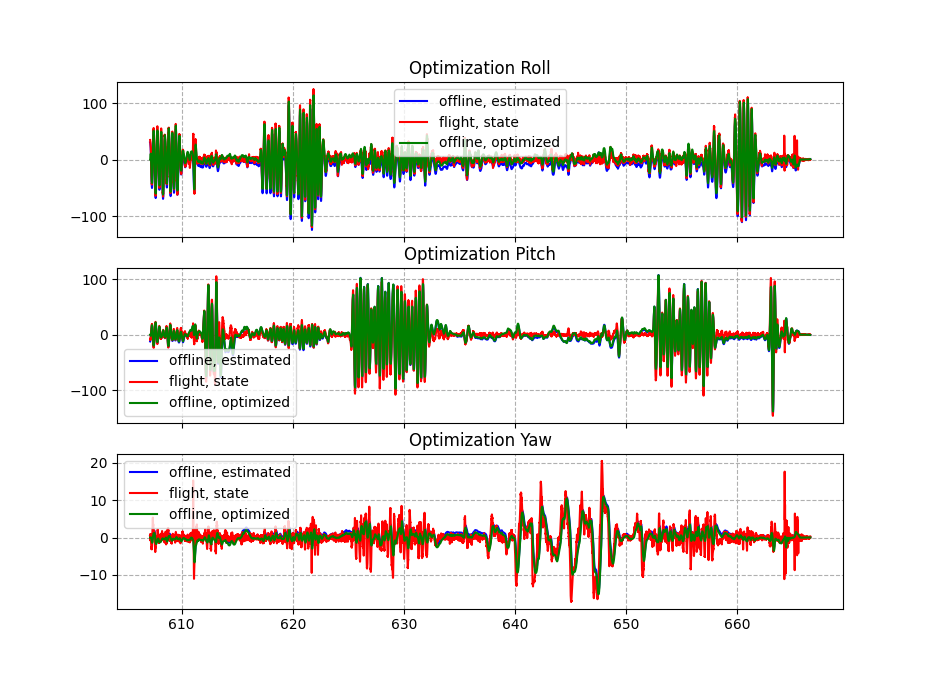

Text(0.5, 1.0, 'Optimization Yaw')

In [15]:
# data for state

roll_accel_flight = df_crop.pd_state_f.array
roll_accel_model_init = df_crop.pd_estimated_f.array
roll_accel_model_opt = model(actuators,popt_roll[0],popt_roll[1],popt_roll[2],popt_roll[3])
pitch_accel_flight = df_crop.qd_state_f.array
pitch_accel_model_init = df_crop.qd_estimated_f.array
pitch_accel_model_opt = model(actuators,popt_pitch[0],popt_pitch[1],popt_pitch[2],popt_pitch[3])
yaw_accel_flight = df_crop.rd_state_f.array
yaw_accel_model_init = df_crop.rd_estimated_f.array
yaw_accel_model_opt = model(actuators,popt_yaw[0],popt_yaw[1],popt_yaw[2],popt_yaw[3])

# plot the matching
f, axs = plt.subplots(3, 1, sharex=True)
t_crop = df_crop.time;

# subplot 1
axs[0].plot(t_crop,roll_accel_model_init,label="offline, estimated", color="b")
axs[0].plot(t_crop,roll_accel_flight,label="flight, state", color="r")
axs[0].plot(t_crop,roll_accel_model_opt,label="offline, optimized", color="g")
axs[0].grid(linestyle='--')
axs[0].legend()
axs[0].set_title('Optimization Roll')

# subplot 2
axs[1].plot(t_crop,pitch_accel_model_init,label="offline, estimated", color="b")
axs[1].plot(t_crop,pitch_accel_flight,label="flight, state", color="r")
axs[1].plot(t_crop,pitch_accel_model_opt,label="offline, optimized", color="g")
axs[1].grid(linestyle='--')
axs[1].legend()
axs[1].set_title('Optimization Pitch')

# subplot 3
axs[2].plot(t_crop,yaw_accel_model_init,label="offline, estimated", color="b")
axs[2].plot(t_crop,yaw_accel_flight,label="flight, state", color="r")
axs[2].plot(t_crop,yaw_accel_model_opt,label="offline, optimized", color="g")
axs[2].grid(linestyle='--')
axs[2].legend()
axs[2].set_title('Optimization Yaw')